In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# !pip install scikit-plot
# !pip install py-postgresql

# 0.0 Imports

In [1]:
import json
import pickle
import warnings
import numpy             as np
import pandas            as pd
import seaborn           as sns
import scipy.stats       as ss
import scikitplot        as skplt
import matplotlib.pyplot as plt
import sklearn.metrics   as mtr



#Connect database
#import psycopg2
#import postgresql.driver as pg_driver

from IPython.core.display  import HTML
from IPython.display       import Image

from tabulate                import tabulate
from matplotlib              import gridspec
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn                 import preprocessing as pp
from sklearn                 import model_selection as ms
from sklearn                 import ensemble as en
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression as lr
from xgboost                 import XGBClassifier as xgb
from scikitplot.metrics      import plot_lift_curve, plot_cumulative_gain
from sklearn.model_selection import cross_val_score, StratifiedKFold,GridSearchCV



## 0.1 Helper Functions

In [2]:
#############################################################################################################

#Section 3.5.1
def num_metrics(num_attributes):
    #Central tendencian - mean, median

    ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #Dispersion - std, min, max, range, skew, kurtosis

    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

    #Concatenate
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
    return metrics

############################################################################################################

# section 6.3.2 
def cramer_v(x, y):
    '''This functions calculates the Cramér V, a measure of association between two nominal variables'''
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / min(kcorr - 1, rcorr - 1))

############################################################################################################
def precision_at_k(df,k=20000):
  #reset index
  df= df.reset_index(drop=True)

  #create ranking order
  df['ranking'] =df.index + 1

  #Calculate precision at k
  df['precision_at_k'] = df['response'].cumsum() /df['ranking']
  
  return df.loc[ k, 'precision_at_k']


def recall_at_k(df,k=20000):
  #reset index
  df= df.reset_index(drop=True)

  #create ranking order
  df['ranking'] =df.index + 1

  #Calculate precision at k
  df['recall_at_k'] = (df['response'].cumsum()) /(df['response'].sum())
  
  return df.loc[ k, 'recall_at_k']

def f1score_at_k(df, k=20000):

    precision = precision_at_k(df, k)
    recall =recall_at_k(df, k)

    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

  
# section 9.0
def cross_validation(model, model_name, x_train, y_train, kfold, df):
    #modelo de cross validation
    kf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    f1score_list = []
    j = 1

  
    #Cross Validation
    for train_cv,val_cv in kf.split(x_train,y_train): #falta o modelo de cross validation antes do .split

        print('\nKfold Number:{}/{}'.format(j,kfold))
    
        #Training and Validation
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        #model
        m = model.fit(x_train_fold, y_train_fold)

        #predict
        yhat = model.predict_proba(x_val_fold)


        #performance
        df = x_val_fold.copy() # copia do dataset de validação
        df['response'] = y_val_fold.copy() # acrescentar a coluna response no dataset
        df['score'] = yhat[:, 1].tolist() #acrescentar a coluna score
        df = df.sort_values('score',ascending=False)    

        #Metrics Precision @k
        precision = precision_at_k(df)
        precision_list.append(precision)
    
        #Metrics Recall @k
        recall = recall_at_k(df)
        recall_list.append(recall)
    
        #Metrics F1score @k
        f1score = f1score_at_k(df)
        f1score_list.append(f1score)
    

        #results mean
        precision_mean, precision_std = (round(np.mean(precision_list), 4),round(np.std(precision_list),4))
        recall_mean, recall_std = (round(np.mean(recall_list), 4),round(np.std(recall_list),4))
        f1_mean, f1_std = (round(np.mean(f1score_list), 4),round(np.std(f1score_list),4))
    
        j+=1

    data = pd.DataFrame({ 'Precision@K Mean': '{}'.format(precision_mean),
                        'Precision@K STD': '+/- {}'.format(precision_std),
                        'Recall@K Mean': '{}'.format(recall_mean),
                        'Recall@K STD': '+/- {}'.format(recall_std),
                        'F1score@K Mean':'{}'.format(f1_mean),
                        'F1score@K STD':'+/- {}'.format(f1_std)}, 
                        index =[model_name])
  
  
    return data

############################################################################################################
  
def jupyter_settings():
    
    %matplotlib inline 
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[12,8]
    plt.rcParams['font.size']=12
    
    display( HTML('<style>.container {width:80% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False )
    
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
# def connect_db ():

#     file_credentials = open('/content/drive/MyDrive/pa004_health_insurance_cross_sell/db/credentials.json')
#     credentials = json.load(file_credentials)

#     try:
#       connect_db = pg_driver.connect(host = credentials['HOST'],
#                                    port = credentials['PORT'],
#                                    database = credentials['DB'],
#                                    user = credentials['USER'],
#                                    password = credentials['PASSWORD'])
#       file_credentials.close()
#       print('Conexão do banco de dados PostreSQL bem-sucedida!\n')

#     except OperationalError as e:
#         print('Erro {} ocorreu.'.format(e))
   
    
#     return connect_db 

In [6]:
#  def pg_query(sql):

#     db = connect_db()
#     query = db.prepare(sql)
#     result = query()
#     db.close()
#     return result

In [3]:
warnings.filterwarnings ('ignore')

# 1.0 Exploration Database


- O módulo psycopg2 permite estabelecer conexão e consultar um banco de dados PostgreSQL e está disponível como um pacote indicador do Linux, macOS ou Windows
- O fetchall () busca todas as linhas no conjunto de resultados e retorna uma lista de tuplas. Se não houver linhas para buscar, o método fetchall () retorna uma lista vazia.

In [8]:
#sql = "SELECT * FROM information_schema.tables WHERE table_type = 'BASE TABLE' AND table_schema = 'pa004';"
#pg_query(sql)

In [9]:
# #Getting tables name from database
#sql = "SELECT * FROM information_schema.tables WHERE table_type = 'BASE TABLE' AND table_schema = 'pa004';"
#pg_query(sql)

In [10]:
# #Exploring database - be more especific
# sql = '''
# SELECT table_schema, table_name FROM information_schema.tables
# WHERE table_type= 'BASE TABLE' AND table_schema='pa004' 
# '''
# pg_query(sql)

In [11]:
# sql = '''
# SELECT column_name, data_type FROM information_schema.columns
# WHERE table_name= 'users' 
# '''
# pg_query(sql)

In [12]:
# sql = '''
# SELECT column_name, data_type FROM information_schema.columns
# WHERE table_name= 'vehicle' 
# '''
# pg_query(sql)

In [13]:
# sql = '''
# SELECT column_name, data_type FROM information_schema.columns
# WHERE table_name= 'insurance' 
# '''
# pg_query(sql)

# 2.0 Loading Dataset

In [14]:
# sql = '''
#   SELECT u.id,
#          u.gender,
#          u.age,
#          u.region_code,
#          u.policy_sales_channel,
#          v.driving_license,
#          v.vehicle_age,
#          v.vehicle_damage,
#          i.previously_insured,
#          i.annual_premium,
#          i.vintage,
#          i.response
#   FROM pa004.users u 
#   LEFT JOIN pa004.vehicle v ON (u.id = v.id)
#   LEFT JOIN pa004.insurance i ON (u.id = i.id)
# '''

# df_raw = pg_query(sql)
# conn.close()

In [15]:
# df_raw.head()

In [16]:
# df_raw.to_csv('../dataset.csv')

In [4]:
#df_raw = pd.read_csv('/content/drive/MyDrive/pa004_health_insurance_cross_sell/dataset.csv', low_memory=False, index_col=[0])

df_raw = pd.read_csv('../dataset.csv', low_memory=False, index_col=[0])

# 3.0 Data Description

In [5]:
df3 = df_raw.copy()

In [25]:
df3.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 3.1 Rename Columns

In [6]:
df3.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

Não é necessário renomear as colunas

## 3.2 Data Dimension

In [20]:
print('Number rows: {}'.format(df3.shape[0]))
print('Number cols: {}'.format(df3.shape[1]))

Number rows: 381109
Number cols: 12


## 3.3 Data Types

In [21]:
df3.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 3.4 Check NA

In [22]:
df3.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

O dataset não possui valores nulos

## 3.5 Descriptive Statistical

In [23]:
#Separate categorical variables from numeric variables
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes= df3.select_dtypes(include = ['object'])

### 3.5.1 Numerical Attributes

In [24]:
num_metrics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 3.5.2 Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

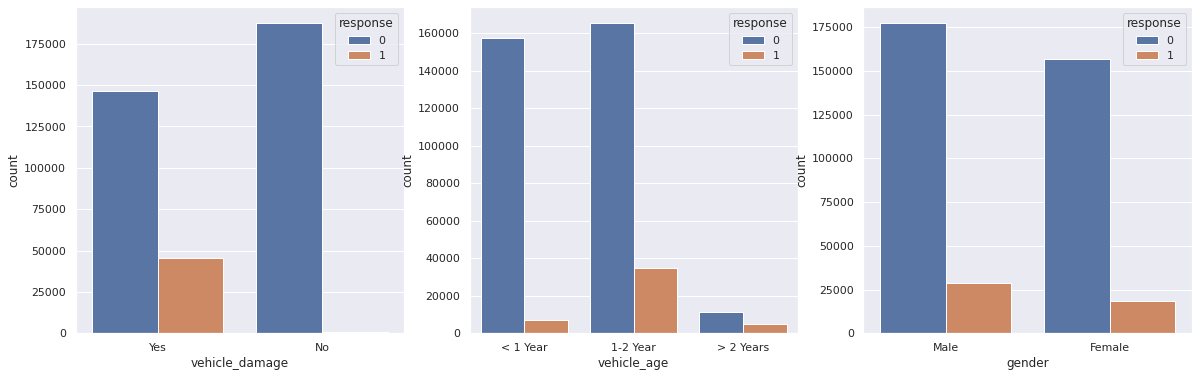

In [26]:
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
sns.countplot(data=df3,x='vehicle_damage',hue='response');

plt.subplot(1, 3, 2)
sns.countplot( data=df3,x='vehicle_age',hue='response');

plt.subplot(1, 3, 3)
sns.countplot(data=df3,x='gender',hue='response');



**Conclusões:**

- A variável age não apresenta valores inconsistentes 
- Pode se perceber na variavel annual_premium que tem uma grande variação nos valores que os clientes pagaram no seguro
- region_code e policy_sales_channel têm skewness negativo, o que significa que as observações estão ligeiramente concentradas no lado direito da distribuição;
- age e year_premium têm uma assimetria positiva baixa, o que significa que as observações estão ligeiramente concentradas no lado esquerdo da distribuição.




# 4.0 - Feature Engineering

## 4.1 Hypothesis Maps

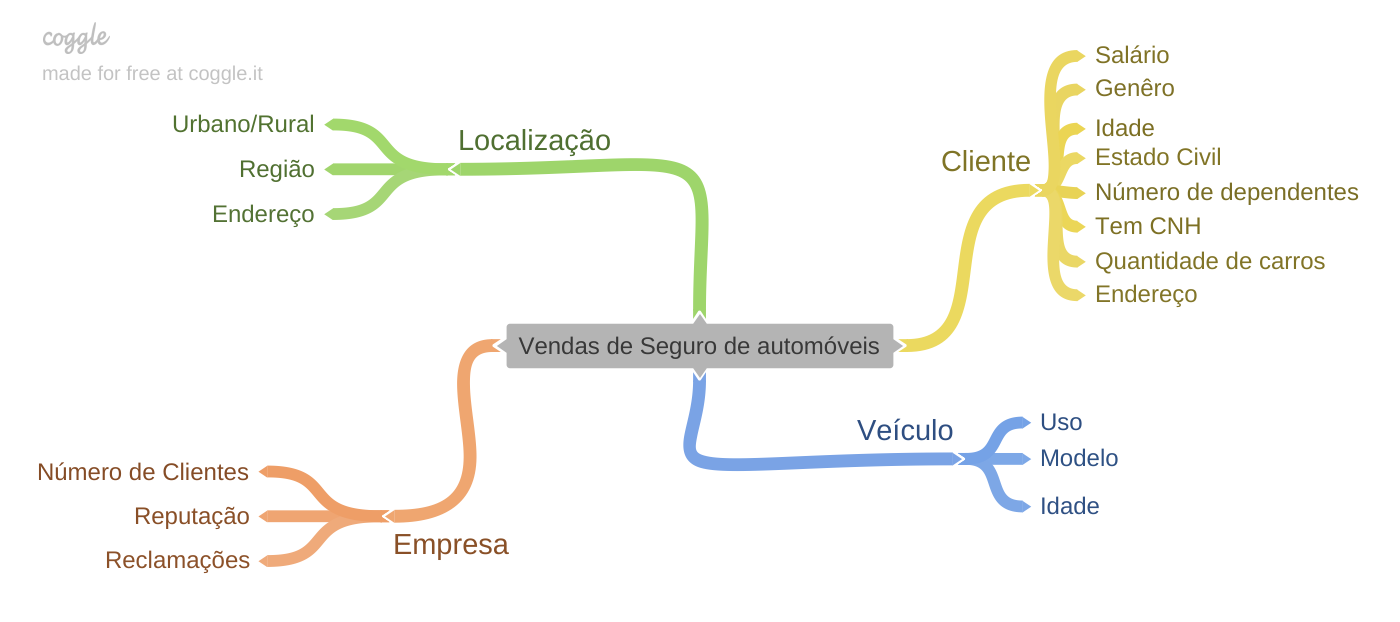

In [5]:
Image('../img/Seguro_de_automveis.png')

## 4.2 Create Hypothesis 

### 4.2.1  Clientes

- 1. Clientes do genêro masculino contratam mais seguro do que do gênero feminino.
- 2. Clientes com idade maior que 30 anos tem maior interesse em contratar seguro.
- 3. Clientes com carteira de habilitação tem maior interesse em contratar seguro.
- 4. Clientes com histórico ruim de direção tem maior interesse de contratar o seguro.
- 5. Clientes com filhos tem maior interesse em contratar seguro.

### 4.2.2  Veículos

- 1. Clientes com modelos de carros do ano tem maior interesse de contratar seguro.
- 2. Clientes com veículos com um maior uso diário tem maior interesse em contratar seguro.

### 4.2.3  Empresa

- 1. Clientes com seguro saúde tem maior interesse de contratar seguro automovel
- 2. Clientes com menor tempo com o seguro saúde tem menor interesse de contratar seguro automovel

### 4.2.4  Localização

- 1. Clientes que moram em zona rural tem menor interesse de contratar seguro automovel
- 2. Clientes que moram em bairros tem maior interesse de contratar seguro automovel


## 4.3 Final Hypothesis

- 1. Clientes com estado civil casado tem maior interesse de contratar seguros.
- 2. Clientes do genêro masculino contratam mais seguro do que do gênero feminino.
- 3. Clientes com idade maior que 40 anos tem maior interesse em contratar seguro.
- 4. Clientes com filhos tem maior interesse em contratar seguro.
- 5. Clientes com modelos de carros do ano tem maior interesse de contratar seguro.
- 6. Clientes com veículos com um maior uso diário tem maior interesse em contratar seguro.
- 7. Clientes com seguro saúde tem maior interesse de contratar seguro automovel



## 4.4 Feature Engineering

In [6]:
df4 = df3.copy()

In [7]:
# Age
df4['age_range']= df4['age'].apply(lambda y: 'young' if y <= 21 else 'adult' if 21 < y < 60 else 'old' if y >= 60 else 'children') 

# Vehicle Age

df4['vehicle_age']= df4['vehicle_age'].apply(lambda y: 'below_1_year' if y == '< 1 Year' else 'between_1_2_year' if y == '1-2 Year'  else 'over_2_years') 


# Vehicle Damage
vehicle_damage_dict = {'No': 0,
                       'Yes': 1}

df4['vehicle_damage']= df4['vehicle_damage'].map(vehicle_damage_dict)

# Gender
df4['gender_binary']= df4['gender'].apply(lambda y: 0 if y == 'Female' else 1) 


In [30]:
df4.sample(5).T

,269482,348109,197219,144706,15985
id,247312,116527,50757,14375,128250
gender,Female,Male,Female,Male,Male
age,44,52,39,22,26
region_code,35,46,8,2,46
policy_sales_channel,124,124,124,152,152
driving_license,1,1,1,1,1
vehicle_age,between_1_2_year,between_1_2_year,between_1_2_year,below_1_year,below_1_year
vehicle_damage,1,1,0,1,0
previously_insured,0,0,0,0,1
annual_premium,2630,32772,28462,31221,22795


# 5.0 Variable Filtering

In [8]:
df5 = df4.copy()

## 5.1 Rows Filtering

Não vai ser necessário filtrar as linhas deste dataset

## 5.2 Selections Columns

Por enquanto não vai ser necessário selecionar colunas do dataset

# 6.0 Exploratory Analysis

In [9]:
df6 = df5.copy()

In [28]:
num_attributes = df6.select_dtypes(exclude='object')
cat_attributes = df6.select_dtypes(include='object')

## 6.1 Univariate Analysis

<AxesSubplot:xlabel='age', ylabel='Count'>

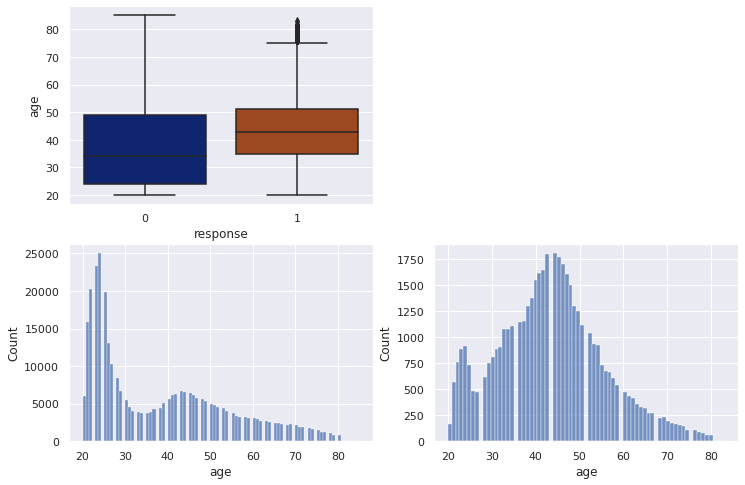

In [27]:
# 'age'
plt.subplot(2,2,1)
sns.boxplot(x='response',y='age',data=df6,palette='dark')

plt.subplot(2,2,3)
aux01 = df6.loc[df6['response'] == 0, 'age']
sns.histplot(aux01,palette='dark')

plt.subplot(2,2,4)
aux02 = df5.loc[df5['response'] == 1, 'age']
sns.histplot(aux02,palette='dark')

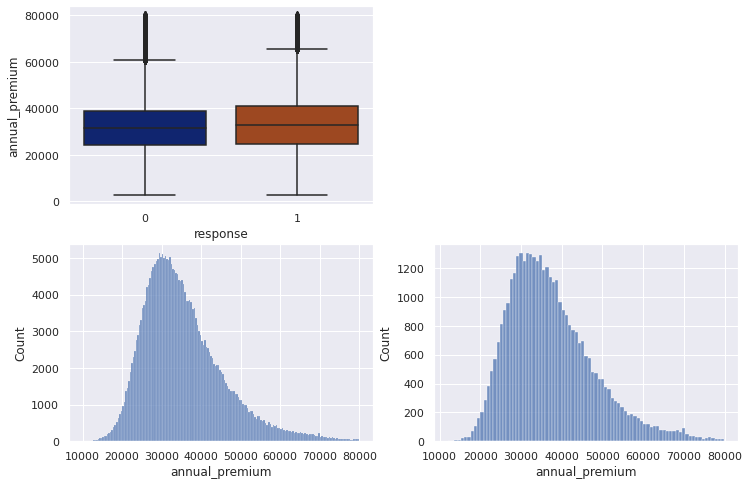

In [26]:
#'annual_premium'
plt.subplot(2,2,1)
aux03 = df6[df6['annual_premium'] < 80000]
sns.boxplot(x='response',y='annual_premium',data=aux03,palette='dark');

plt.subplot(2,2,3)
aux = df6[(df6['annual_premium'] > 10000) & (df6['annual_premium'] < 80000)]
aux01 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux01,palette='dark');

plt.subplot(2,2,4)
aux02 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux02,palette='dark');

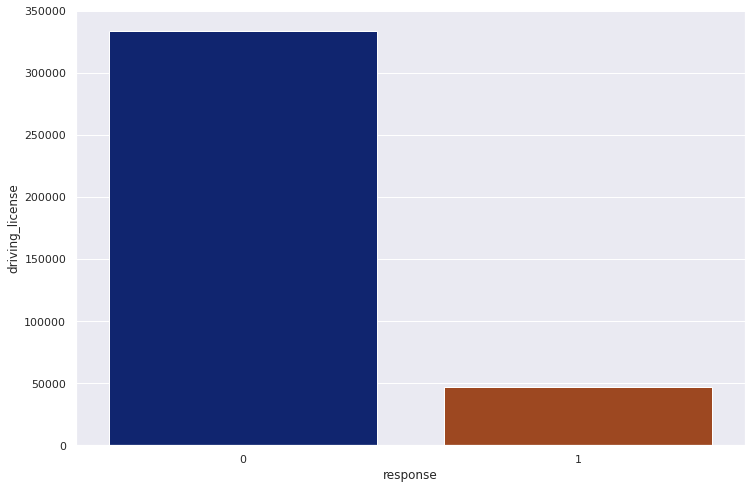

In [25]:
#'driving_license'
aux = df6[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response',y='driving_license',data=aux,palette='dark');

In [90]:
aux['driving_license_perc']= np.round(aux['driving_license']/ aux['driving_license'].sum(), 3) * 100 
aux

,response,driving_license,driving_license_perc
0,0,333628,87.7
1,1,46669,12.3


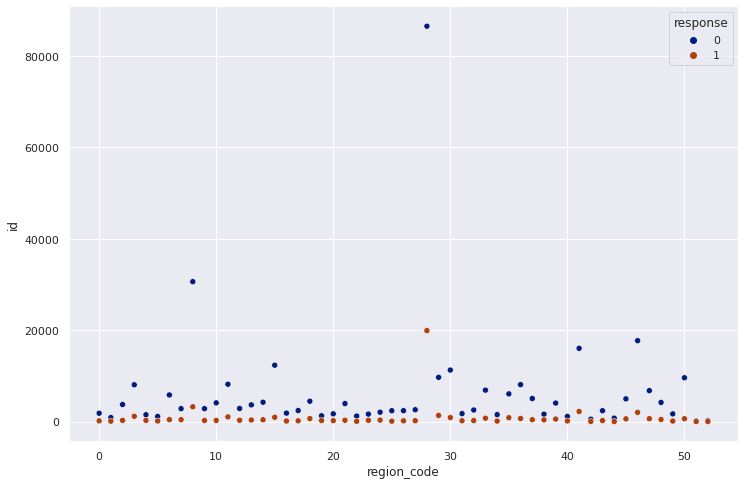

In [24]:
#'region_code'
aux = df6[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code',y='id',hue='response', data=aux,palette='dark');

In [92]:
#'previously_insured'
pd.crosstab(df6['previously_insured'],df6['response']).apply(lambda x: x/ x.sum(),axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [93]:
#'vehicle_age'
aux = df6[['id','vehicle_age','response']].groupby(['vehicle_age','response']).count().reset_index()
aux

,vehicle_age,response,id
0,below_1_year,0,157584
1,below_1_year,1,7202
2,between_1_2_year,0,165510
3,between_1_2_year,1,34806
4,over_2_years,0,11305
5,over_2_years,1,4702


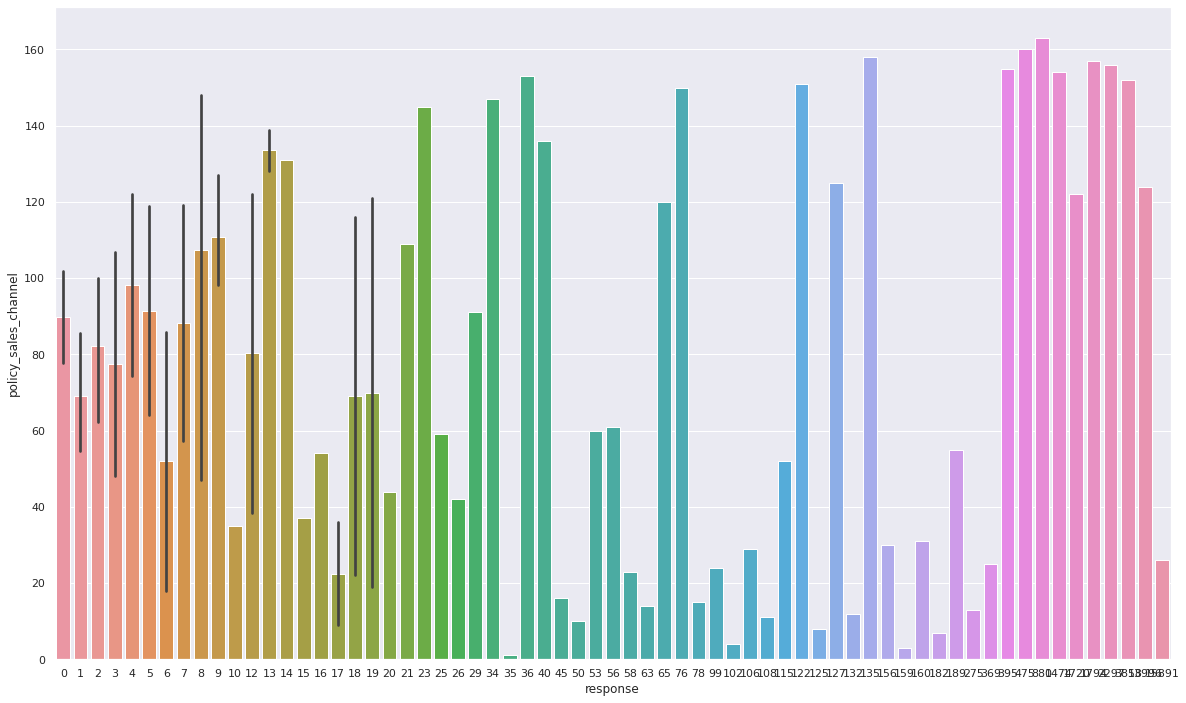

In [94]:
#'policy_sales_channel'
plt.figure(figsize=(20,12))
aux = df6[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response',y='policy_sales_channel', data=aux);

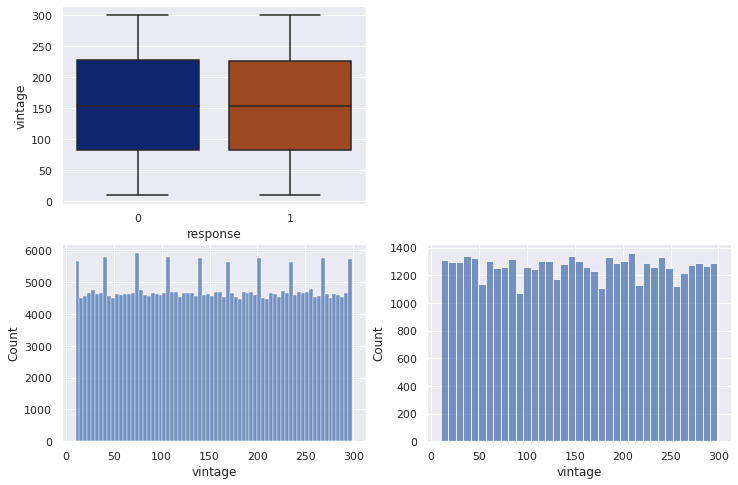

In [23]:
#'vintage'
plt.subplot(2,2,1)
sns.boxplot(x='response',y='vintage',data=df6,palette='dark');

plt.subplot(2,2,3)

aux01 = df6.loc[df6['response'] == 0, 'vintage']
sns.histplot(aux01,palette='dark');

plt.subplot(2,2,4)
aux02 = df6.loc[df6['response'] == 1, 'vintage']
sns.histplot(aux02,palette='dark');

In [11]:
# 'gender'
df6['gender'].value_counts()

Male      206089
Female    175020
Name: gender, dtype: int64

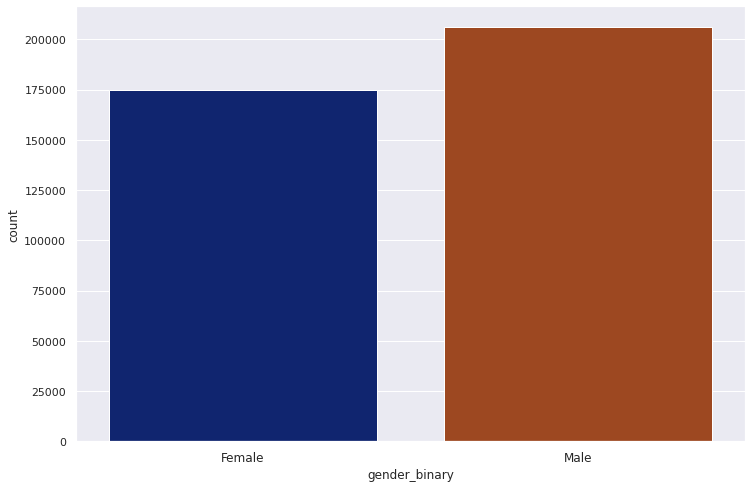

In [10]:
sns.countplot(x='gender_binary', data=df6,palette='dark');
plt.xticks(np.arange(2),['Female','Male'], size=12);

In [14]:
df6['vehicle_damage'].value_counts()

1    192413
0    188696
Name: vehicle_damage, dtype: int64

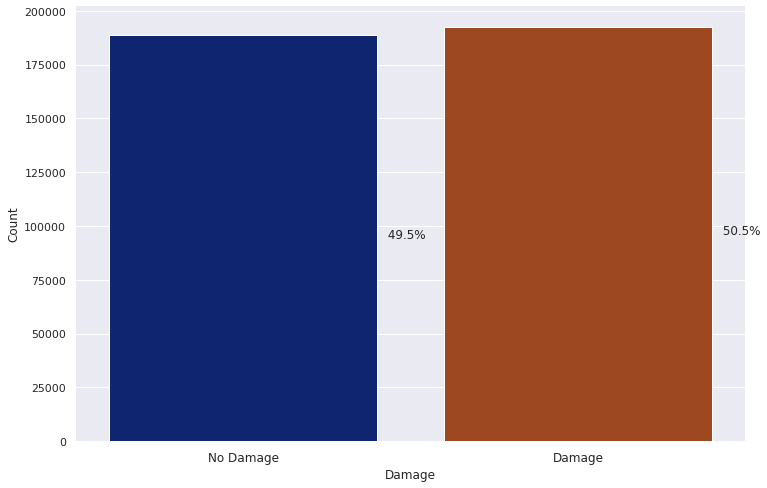

In [16]:
#'vehicle_damage'
ax = sns.countplot(x='vehicle_damage', data=df6,palette='dark');
plt.xticks(np.arange(2),['No Damage','Damage'], size=12);
plt.xlabel('Damage')
plt.ylabel('Count')
sns.despine( bottom=True, left=True)

total = df6['vehicle_damage'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

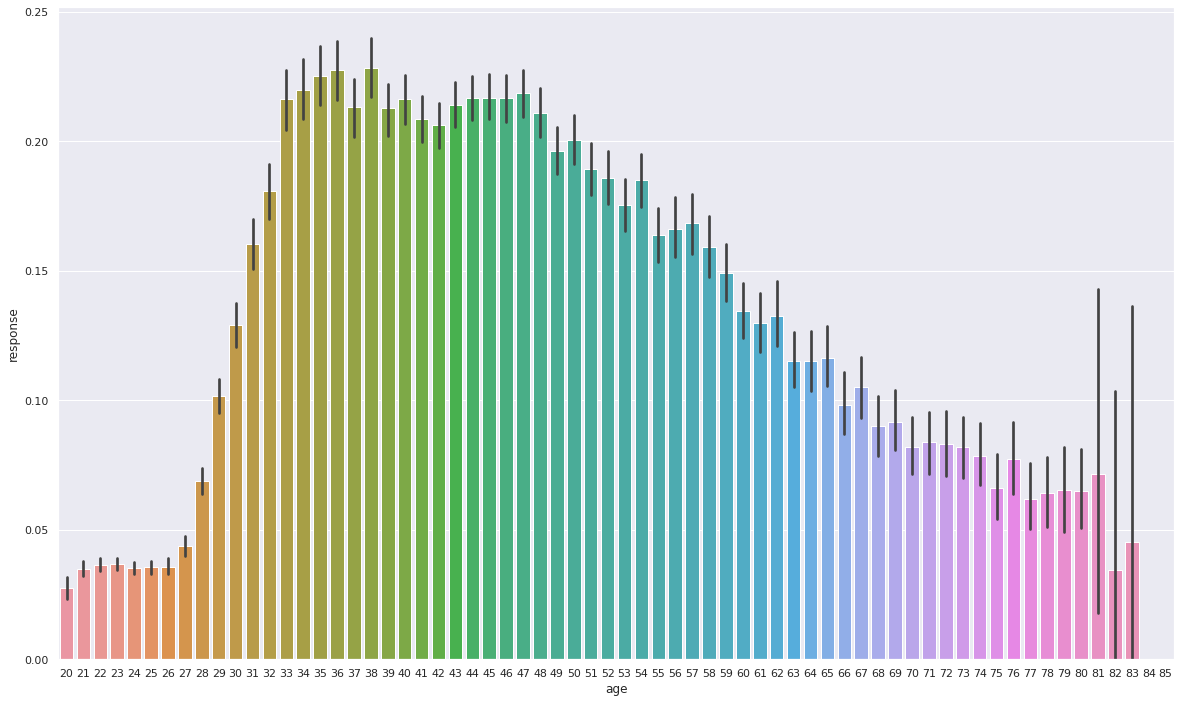

In [21]:
#'age'
plt.figure(figsize=(20,12))
sns.barplot(x='age',y='response', data=df6);

### 6.1.1 Response Variable

In [99]:
df6['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

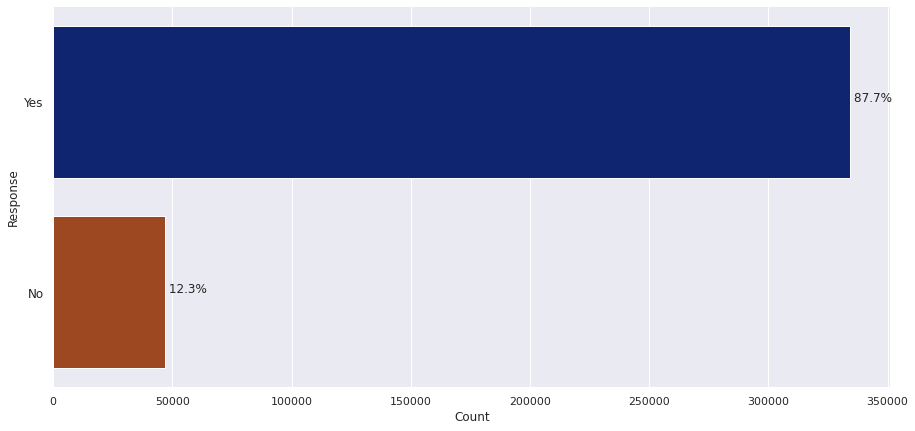

In [100]:
plt.figure(figsize=(15,7))
aux = sns.countplot(y='response', data=df6, palette="dark");
sns.set_style('whitegrid')
plt.xlabel('Count')
plt.ylabel('Response')
plt.yticks(np.arange(2),['Yes','No'], size=12)
sns.despine( bottom=True, left=True)


total = df3['response'].size

for p in aux.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        aux.annotate(percentage, (x, y))

### 6.1.2 Numerical Variable

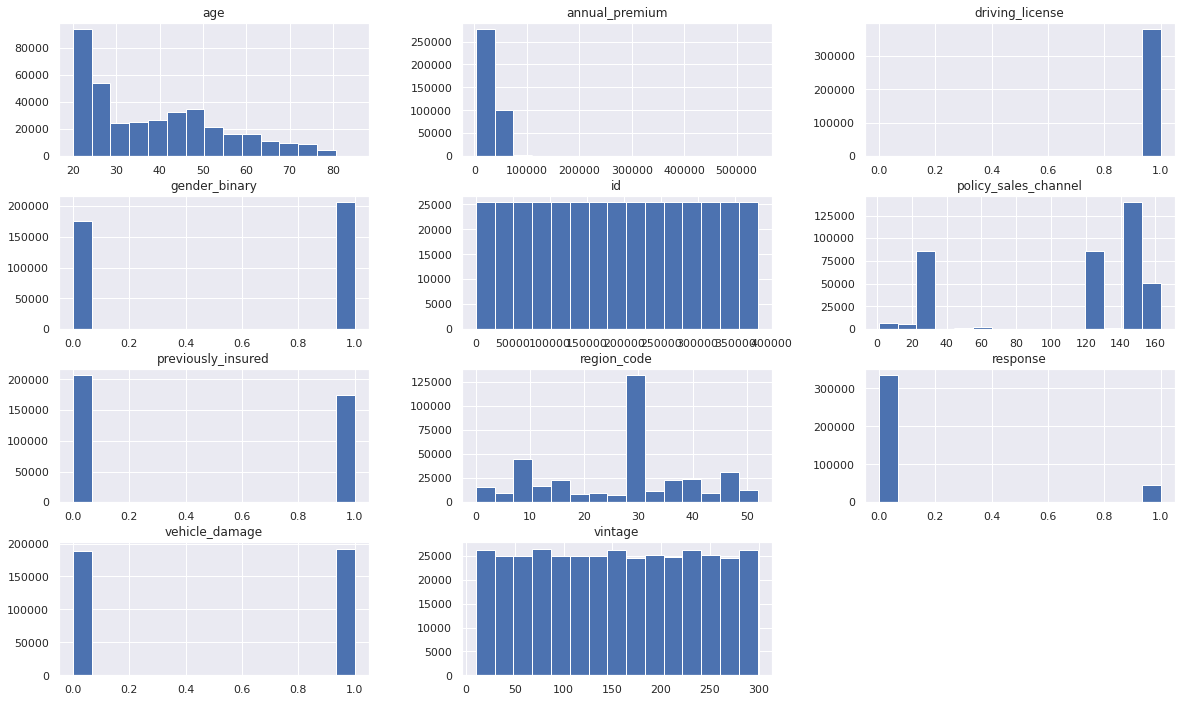

In [29]:
num_attributes.hist(bins=15,figsize=(20,12));

### 6.1.3 Categorical Variable

In [103]:
cat_attributes.describe()

,gender,vehicle_age,age_range
count,381109,381109,381109
unique,2,3,3
top,Male,between_1_2_year,adult
freq,206089,200316,311647


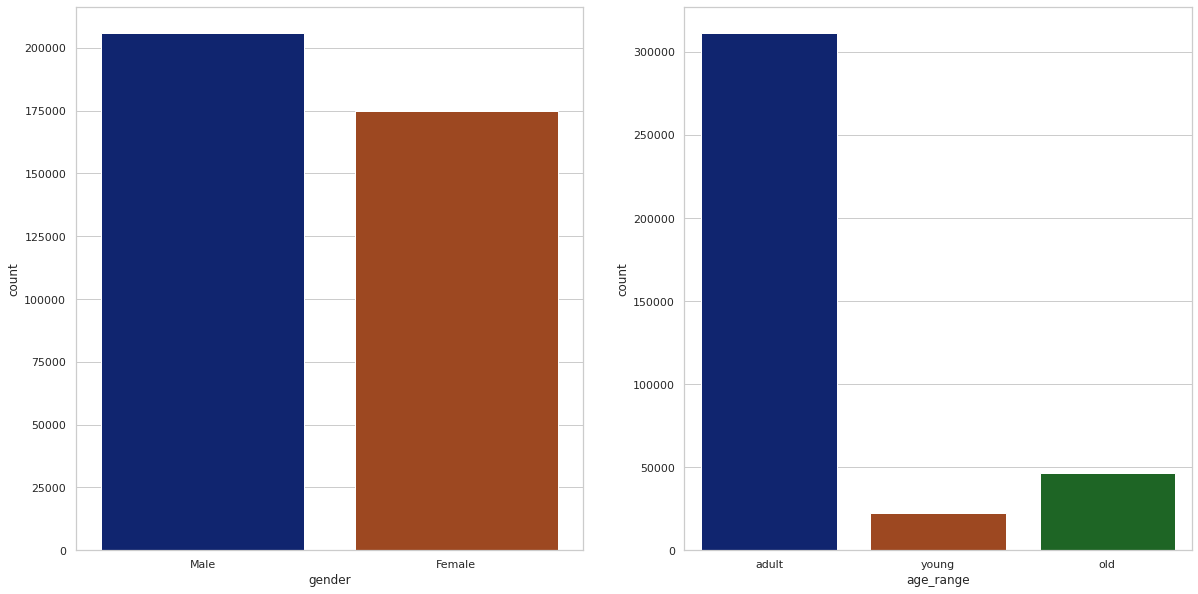

In [104]:
plt.subplots( figsize = ( 20,10 ))

plt.subplot(1, 2, 1);
sns.countplot(cat_attributes['gender'],palette="dark");

plt.subplot(1, 2, 2);
sns.countplot(cat_attributes['age_range'],palette="dark");

## 6.2 Bivariate Analysis

In [105]:
df6.head(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_range,gender_binary
0,7,Male,23,11.0,152.0,1,below_1_year,1,0,23367.0,249,0,adult,1
1,13,Female,41,15.0,14.0,1,between_1_2_year,0,1,31409.0,221,0,adult,0
2,18,Female,25,35.0,152.0,1,below_1_year,0,1,46622.0,299,0,adult,0
3,31,Female,26,8.0,160.0,1,below_1_year,0,0,2630.0,136,0,adult,0
4,39,Male,45,8.0,124.0,1,between_1_2_year,1,0,42297.0,264,0,adult,1


### H1. Clientes do genêro masculino contratam mais seguro do que do gênero feminino.


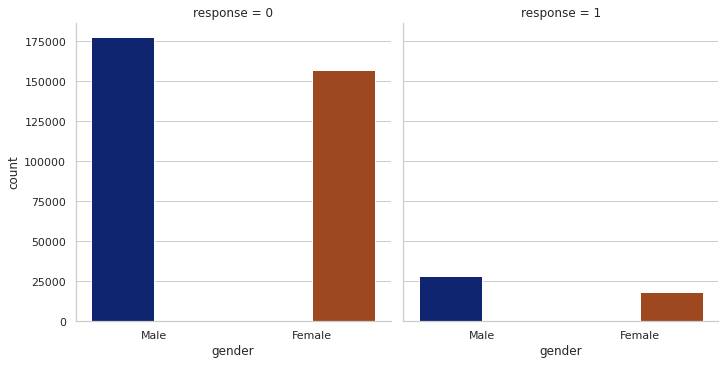

In [52]:
sns.catplot(data=df6, kind="count",x="gender",  col="response", hue="gender", palette="dark");

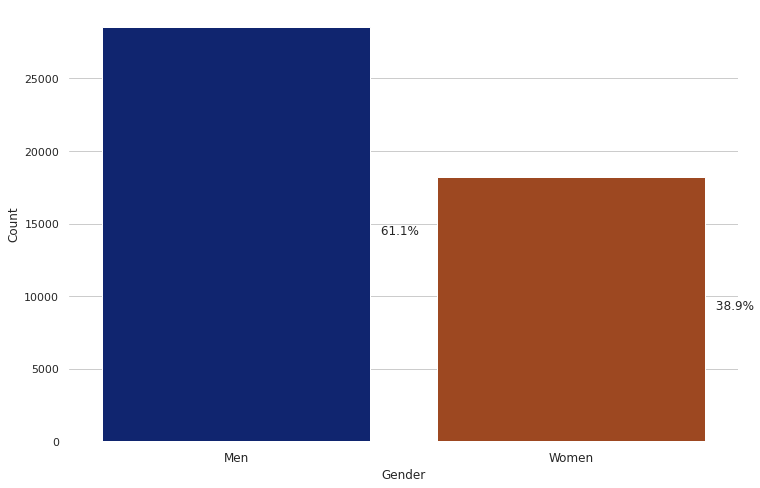

In [53]:
aux  = df6[df6['response']== 1]

ax = sns.countplot(x='gender', data=aux,palette='dark');
plt.xticks(np.arange(2),['Men','Women'], size=12)
plt.xlabel('Gender')
plt.ylabel('Count')
sns.despine( bottom=True, left=True)

total = aux['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H2. Clientes com idade maior que 40 anos tem maior interesse em contratar seguro.
**Verdadeira **


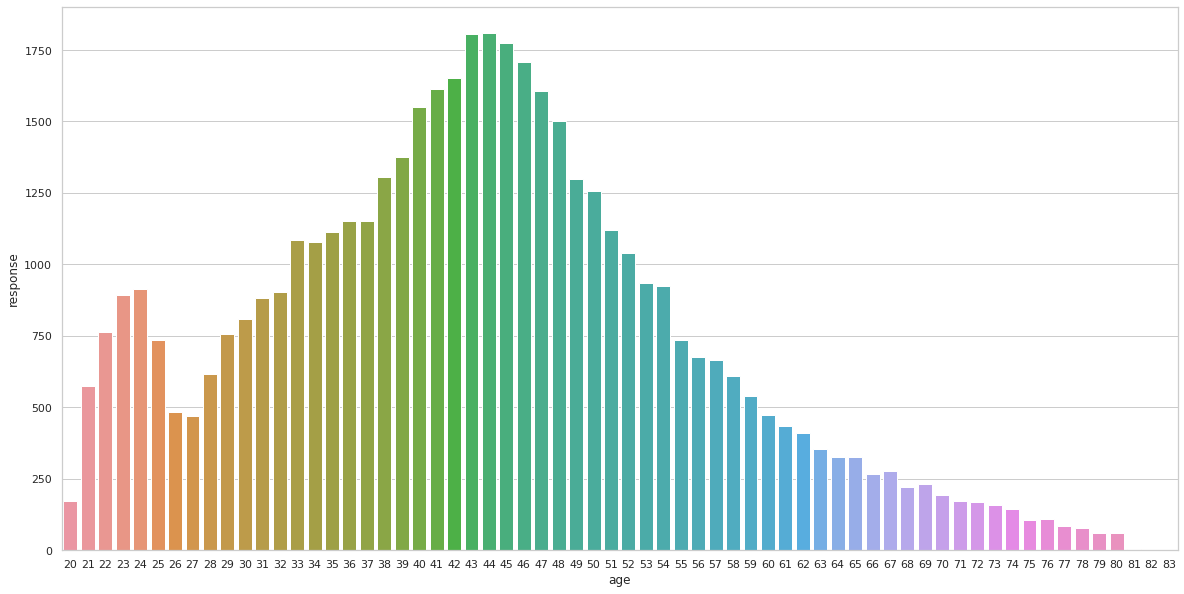

In [107]:
plt.figure(figsize=(20,10))
aux = df6[df6['response']== 1]

aux1 = aux[['age', 'response']].groupby('age').sum().reset_index()


sns.barplot(x='age',y='response', data=aux1);

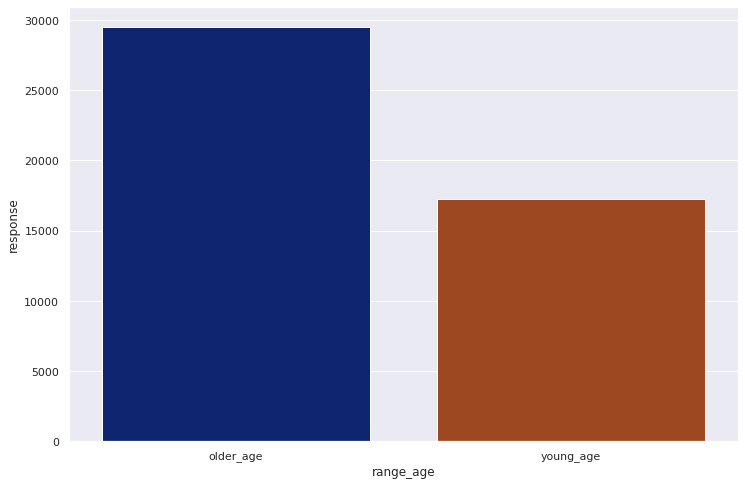

In [72]:
aux['range_age'] = aux['age'].apply(lambda x: 'young_age' if x < 40 else 'older_age')
aux1 = aux[['range_age', 'response']].groupby('range_age').sum().reset_index()

ax = sns.barplot(x='range_age', y='response', data= aux1,palette='dark');


### H3. Clientes com carteira de habilitação tem maior interesse em contratar seguro



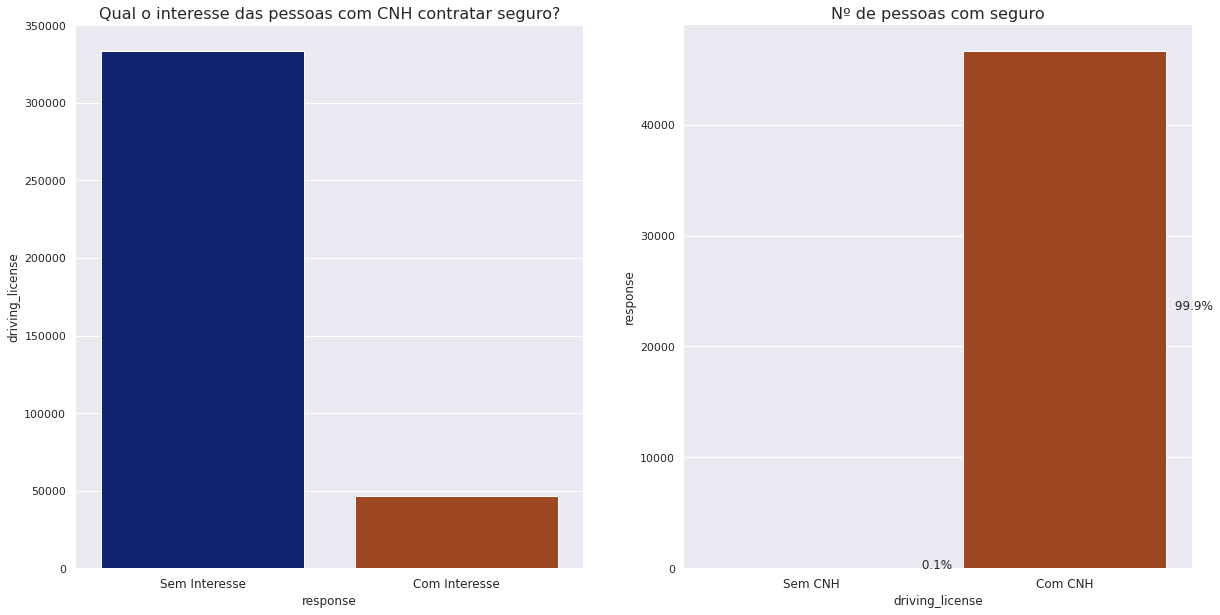

In [17]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
aux01= df6[df6['driving_license']==1]
aux02= aux01[['response','driving_license']].groupby('response').sum().reset_index()

#plotando o gráfico
ax1 = sns.barplot(x='response', y='driving_license', data= aux02,palette='dark');
plt.title('Qual o interesse das pessoas com CNH contratar seguro?', size = 16)
plt.xticks(np.arange(2), ['Sem Interesse', 'Com Interesse'], size = 12)

sns.despine( bottom=True, left=True)

plt.subplot(1,2,2)
aux03= df6[df6['response']== 1]
aux04= aux03[['response','driving_license']].groupby('driving_license').sum().reset_index()

#plotando o gráfico
ax = sns.barplot(x='driving_license', y='response', data= aux04,palette='dark');
plt.title('Nº de pessoas com seguro', size = 16)
plt.xticks(np.arange(2), ['Sem CNH', 'Com CNH'], size = 12)

sns.despine( bottom=True, left=True)

total01 = aux03['driving_license'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total01)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


### H4. Clientes com carros mais novos tem maior interesse de contratar seguro.


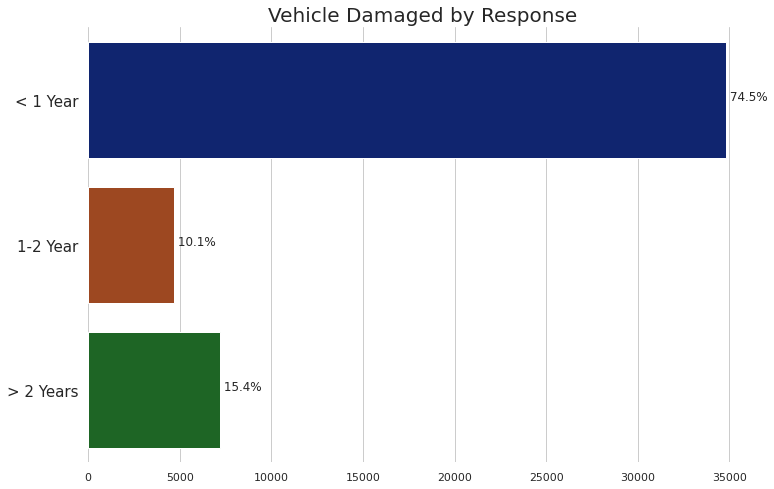

In [56]:
aux01= df6[df6['response']== 1]

ax = sns.countplot(y='vehicle_age',data=aux01,palette='dark');

plt.title('Vehicle Damaged by Response', size = 20)
plt.yticks(np.arange(3), ['< 1 Year', '1-2 Year','> 2 Years'], size = 15)

plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)

total = aux01['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))




### H5. Clientes com veículos danificados anteriormente tem maior interesse de contratar seguro.

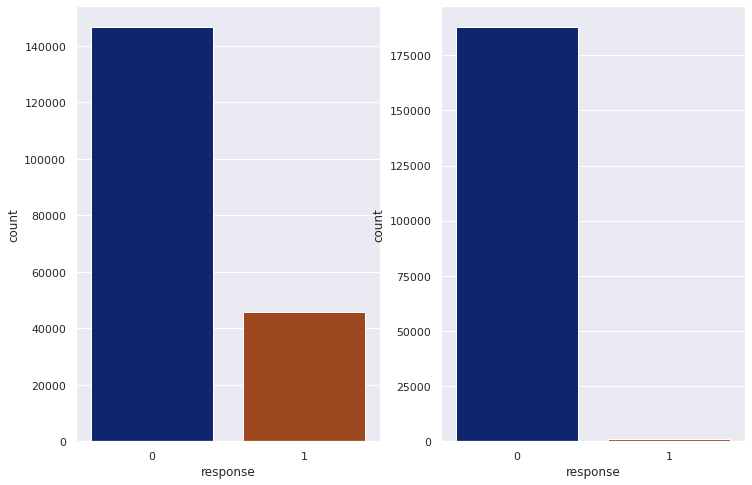

In [81]:
plt.subplot(1,2,1)
aux01 = df6[df6['vehicle_damage'] == 1]

sns.countplot(x='response',data=aux01,palette='dark');



plt.subplot(1,2,2)
aux02 = df6[df6['vehicle_damage'] == 0]

sns.countplot(x='response',data=aux02,palette='dark');



### H7. Clientes com seguro automóvel a mais tempo tem maior interesse de contratar.

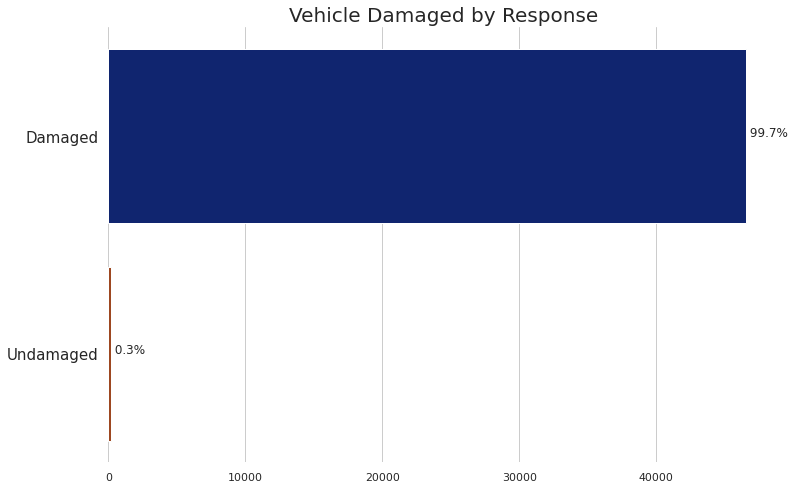

In [58]:
aux01 = df6[df6['response'] == 1]

ax = sns.countplot(y='previously_insured',data=aux01,palette='dark');

sns.set_style('whitegrid')
plt.title('Vehicle Damaged by Response', size = 20)
plt.yticks(np.arange(2), ['Damaged', 'Undamaged'], size = 15)

plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)

total = aux01['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))



## 6.3 Multivariate Analisys

### 6.3.1 Numerical Attributes

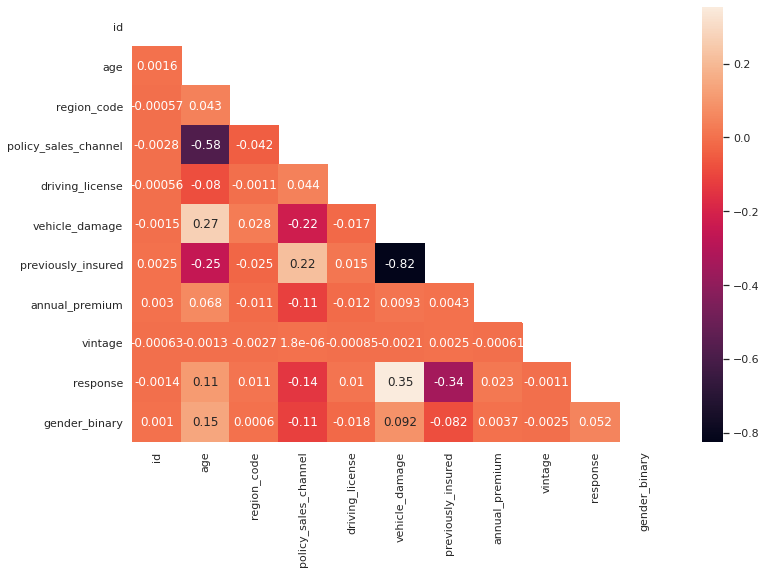

In [60]:
correlation = num_attributes.corr(method='pearson')

# Creating a with mask for the superior triangle
ax = np.zeros_like(correlation)
ax[np.triu_indices_from(ax)] = True


sns.heatmap(correlation,mask=ax, annot=True);

### 6.3.2 Categorical Attributes

In [61]:
a = df5.select_dtypes(include='object')
a.columns

Index(['gender', 'vehicle_age', 'age_range'], dtype='object')

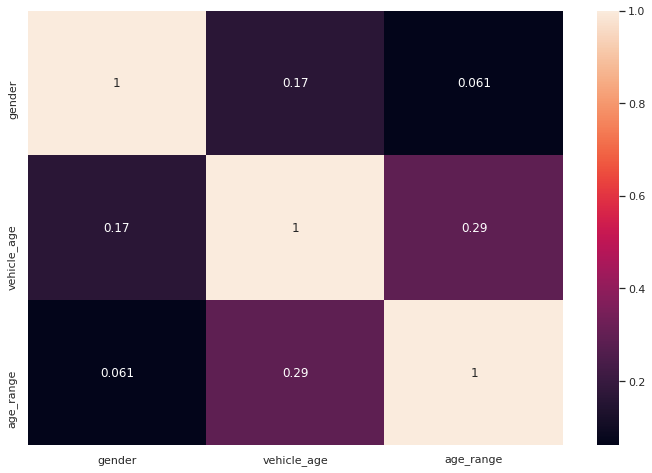

In [62]:

# only categorical data
a = df5.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['age_range'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['age_range'])

a7 = cramer_v(a['age_range'], a['gender'])
a8 = cramer_v(a['age_range'], a['vehicle_age'])
a9 = cramer_v(a['age_range'], a['age_range'])

#Final Dataset

data = pd.DataFrame({'gender':[a1,a2,a3],
                     'vehicle_age':[a4,a5,a6],
                     'age_range':[a7,a8,a9]})

data = data.set_index(data.columns)
sns.heatmap(data,annot=True);

# 7.0 Balanceamento

Temos 4 formas de técnicas de balanceamento sendo elas:

1. Coleta de mais dados (Neste dataset não é possível)
2. Reamostrar os dados (Realizar cópias dos meus dados originais)
3. Gerar dados sintéticos
4. Atribuir viés ao modelo 

 ## 7.1 SMOTE + TOMEKLINK

In [12]:
import imblearn.combine  as smt

In [58]:
df7 = df6.copy()

In [59]:
df7[['male', 'female']] = pd.get_dummies(df7['gender'])
df7['vehicle_age'] = df7['vehicle_age'].map( {'below_1_year':1, 'between_1_2_year':2, 'over_2_years':3})

df71 = df7.drop(['id', 'gender','age_range', 'response'], axis =1).copy()

In [102]:
df6.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_range,gender_binary
0,7,Male,23,11.0,152.0,1,below_1_year,1,0,23367.0,249,0,adult,1
1,13,Female,41,15.0,14.0,1,between_1_2_year,0,1,31409.0,221,0,adult,0
2,18,Female,25,35.0,152.0,1,below_1_year,0,1,46622.0,299,0,adult,0
3,31,Female,26,8.0,160.0,1,below_1_year,0,0,2630.0,136,0,adult,0
4,39,Male,45,8.0,124.0,1,between_1_2_year,1,0,42297.0,264,0,adult,1


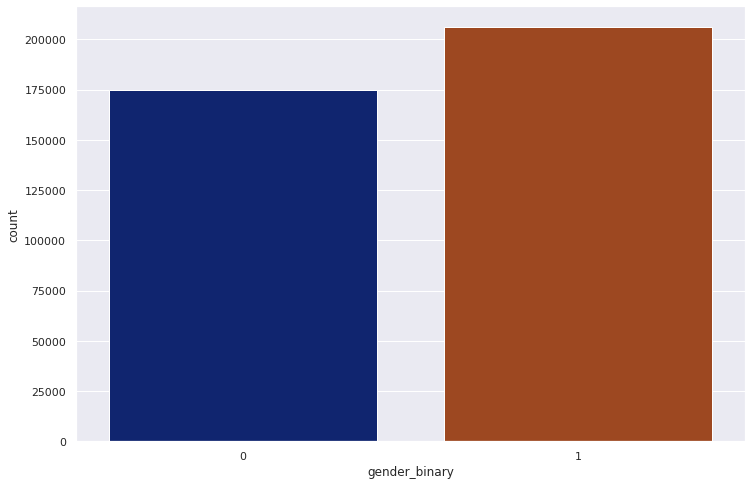

In [105]:
#df6['gender'].value_counts()

sns.countplot(x='gender_binary', data=df6,palette='dark');

In [61]:
ratio_balanced = {0: 334399,
                  1: 5*46710}

In [62]:
# define sampler
balanced = smt.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = balanced.fit_resample( df71, df7['response'] )

In [63]:
# saving the balanced dataset into df21
df71 = X_smt.copy()
df71['gender'] = df71[['male', 'female']].idxmax(axis=1)
df71['response'] = y_smt

df7_balanced = df71.drop(['male', 'female'], axis = 1)

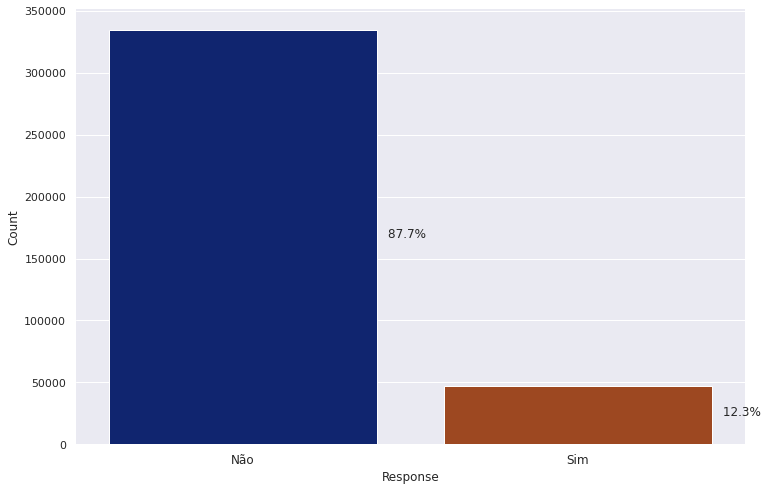

In [65]:
#Gráficos com dados sem balancear
aux  = df7.copy()

ax = sns.countplot(x='response', data=aux,palette='dark');
plt.xticks(np.arange(2),['Não','Sim'], size=12)
plt.xlabel('Response')
plt.ylabel('Count')
sns.despine( bottom=True, left=True)

total = aux['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

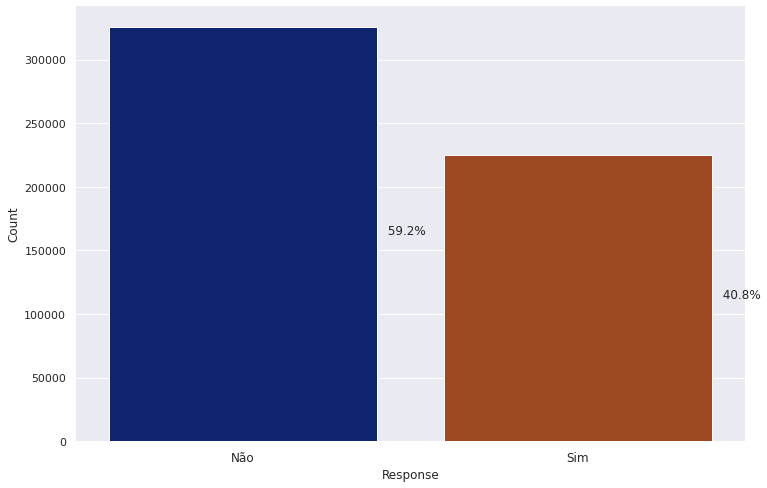

In [66]:
#Gráficos com dados balanceados
aux  = df7_balanced.copy()

ax = sns.countplot(x='response', data=aux,palette='dark');
plt.xticks(np.arange(2),['Não','Sim'], size=12)
plt.xlabel('Response')
plt.ylabel('Count')
sns.despine( bottom=True, left=True)

total = aux['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

# 8.0 Data Preparation

In [67]:
df8 = df7_balanced.copy()

In [68]:
X =  df8.drop('response',axis=1)
y = df8['response'].copy()

x_train, x_validation,y_train,y_validation = ms.train_test_split(X, y, test_size=0.20)

df8 = pd.concat([x_train,y_train], axis=1) 

## 8.1  Rescaling

In [69]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

In [70]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df8['age'] = mms_age.fit_transform( df8[['age']].values )
pickle.dump(mms_age,open('../src/features/age_scaler.pkl','wb'))

#vintage
df8['vintage'] = mms_vintage.fit_transform(df8[['vintage']].values )
pickle.dump(mms_vintage,open('../src/features/vintage_scaler.pkl','wb'))

## 8.2 Encoding

In [71]:
#gender
target_encode_gender = df8.groupby('gender')['response'].mean()
df8.loc[:,'gender']= df8['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender,open('../src/features/target_encode_gender_scaler.pkl','wb'))

#region_code
target_encode_region_code = df8.groupby('region_code')['response'].mean()
df8.loc[:,'region_code']= df8['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code,open('../src/features/target_encode_region_code_scaler.pkl','wb'))

#vehicle_age
df8 = pd.get_dummies(df8,prefix='vehicle_age',columns=['vehicle_age'])

#policy_sales_channel
fe_policy_sales_channel = df8.groupby('policy_sales_channel').size() / len(df8)
df8.loc[:,'policy_sales_channel']= df8['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel,open('../src/features/fe_policy_sales_channel_scaler.pkl','wb'))


## 8.3 Standardization

In [72]:
ss = pp.StandardScaler()

In [73]:
df8['annual_premium'] = ss.fit_transform( df8[['annual_premium']].values )
pickle.dump(ss,open('../src/features/annual_premium_scaler.pkl','wb'))

## 8.4 Validation Preparation

In [74]:
#gender
x_validation.loc[:,'gender'] = x_validation.loc[:,'gender'].map(target_encode_gender)

#age
x_validation.loc[:,'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:,'region_code'] = x_validation.loc[:,'region_code'].map(target_encode_region_code)

#vehicle_age
x_validation = pd.get_dummies(x_validation,prefix='vehicle_age',columns=['vehicle_age'])

#annual_premium
x_validation['annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values )

#policy_sales_channel
x_validation.loc[:,'policy_sales_channel']= x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

#vintage
x_validation['vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values )

#fillna
x_validation = x_validation.fillna(0)

# 9.0 Features Selection

## 9.1 Feature Importance

In [71]:
# #definição do modelo
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# # Preparação dos Dados
# x_train_n = df7.drop(['id','response','age_range'],axis=1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [72]:
# importance = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importance)[::-1]

# #Print the feature ranking
# print('Feature Ranking:')
# df = pd.DataFrame()

# for i,j in zip(x_train_n,forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance':j}, index=[0])
#     df = pd.concat([df,aux], axis=0)

# print(df.sort_values('importance',ascending=False))

# #Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature importances')
# plt.bar(range(x_train_n.shape[1]),importance[indices],color='r',yerr=std[indices],align='center')
# plt.xticks(range(x_train_n.shape[1]),indices)
# plt.xlim([-1,x_train_n.shape[1]])
# plt.show();

# 9.0 Machine Learning

In [73]:
# Usar a variável x_val ( não tem a variável id) para as validações, 
#e usar a variável x_validation (tem a variável id) para o cálculo de performance, 

In [75]:
cols_selected =['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

x_train = df8[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

### 9.0.1 Verificando as variáveis

In [75]:
x_train.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
368477,0.529412,2.425120,0.353846,0.122383,0,0.208694,0
55329,0.993080,0.340642,0.215385,0.112967,1,0.208694,1
269979,0.211073,-0.002424,0.507692,0.187426,1,0.194118,0
260705,0.342561,0.145581,0.338462,0.104029,0,0.208694,1
292787,0.089965,-0.290148,0.261538,0.072374,0,0.354089,1


In [76]:
x_val.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
22782,0.588235,0.838281,0.338462,0.187426,0,0.194118,1
77142,0.387543,0.018685,0.692308,0.061471,0,0.004018,1
13215,0.557093,0.459586,0.615385,0.187426,1,0.208694,0
109254,0.892734,0.876896,0.307692,0.187426,1,0.015789,0
75116,0.217993,0.560466,0.646154,0.122820,1,0.194118,0


In [77]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,age_range,gender_binary,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
22782,181856,0.103887,0.338462,0.187426,0.194118,1,0,1,0.838281,0.588235,adult,0,0,1,0
77142,233886,0.138728,0.692308,0.061471,0.004018,1,0,1,0.018685,0.387543,old,1,0,1,0
13215,106507,0.103887,0.615385,0.187426,0.208694,1,1,0,0.459586,0.557093,old,0,0,1,0
109254,110208,0.103887,0.307692,0.187426,0.015789,1,1,0,0.876896,0.892734,adult,0,0,1,0
75116,217892,0.103887,0.646154,0.122820,0.194118,1,1,0,0.560466,0.217993,old,0,0,1,0


In [78]:
y_validation.head()

22782     0
77142     0
13215     1
109254    0
75116     0
Name: response, dtype: int64

In [79]:
#y_train.head()

## 9.1 KNeighbors Classifier

In [76]:
# model definition
knn_model = KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train,y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

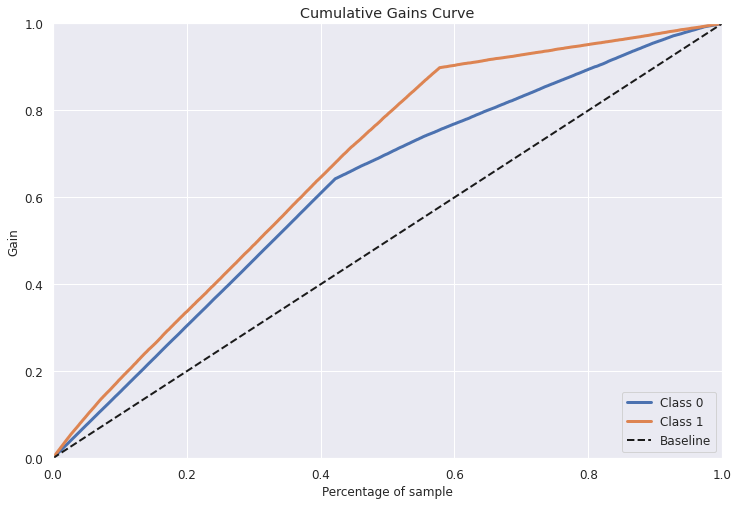

In [77]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn);

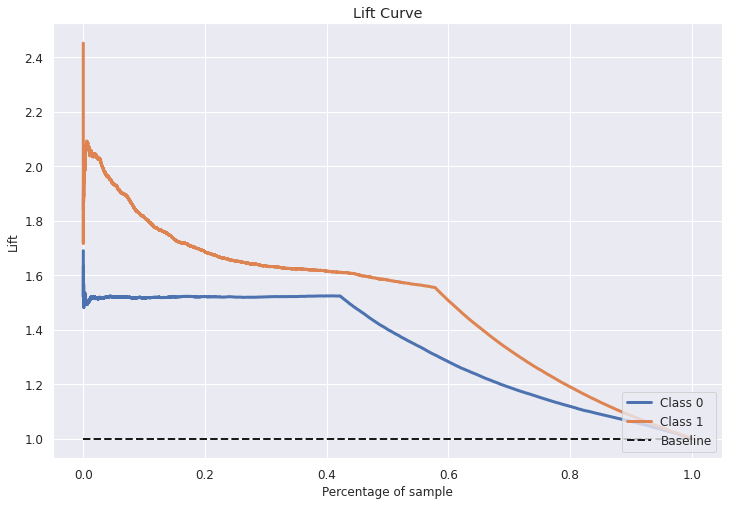

In [78]:
plot_lift_curve(y_validation, yhat_knn);


### 9.1.1 Métrica KNN

In [79]:
# copy data
data = x_validation.copy()
data['response'] = y_validation.copy()

# propensity score
data['score'] = yhat_knn[:, 1].tolist()

# sorte clients by propensity score
data = data.sort_values('score', ascending=False)

# compute precision at k
precision_at_knn = precision_at_k(data, k=20000)
print('Precision at K: {}'.format(precision_at_knn))

# compute recall at k
recall_at_knn = recall_at_k(data, k=20000)
print('Recall at K: {}'.format(recall_at_knn))

# compute f1score at k
f1score_at_knn = f1score_at_k(data, k=20000)
print('F1score at K: {}'.format(f1score_at_knn))

Precision at K: 0.6922153892305385
Recall at K: 0.30842745438748914
F1score at K: 0.42672214516874707


### 9.1.2 Cross Validation

In [80]:
knn_results_cv = cross_validation(KNeighborsClassifier(n_neighbors=7), 'KNeighbors Classifier',x_train, y_train,5,df7)
knn_results_cv


Kfold Number:1/5

Kfold Number:2/5

Kfold Number:3/5

Kfold Number:4/5

Kfold Number:5/5


,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD,F1score@K Mean,F1score@K STD
KNeighbors Classifier,0.9808,+/- 0.0006,0.5458,+/- 0.0003,0.7013,+/- 0.0004


## 9.2 Logistic Regression

In [81]:
# model definition
lr_model = lr(random_state=42)

# model training
lr_model.fit(x_train,y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

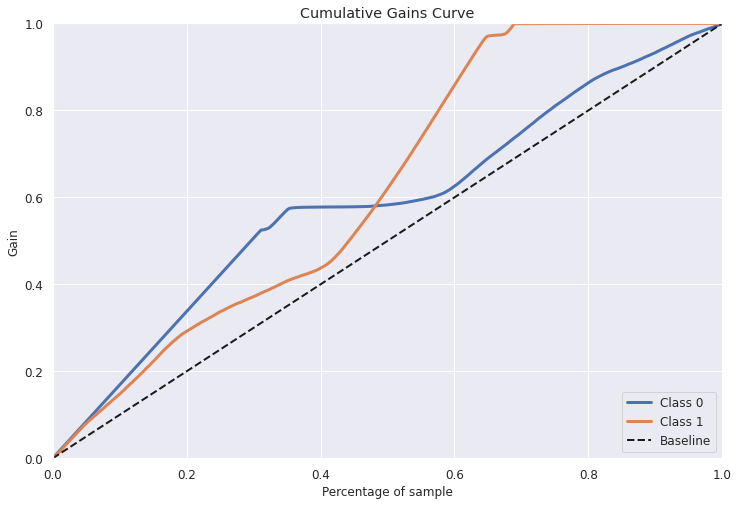

In [82]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr);

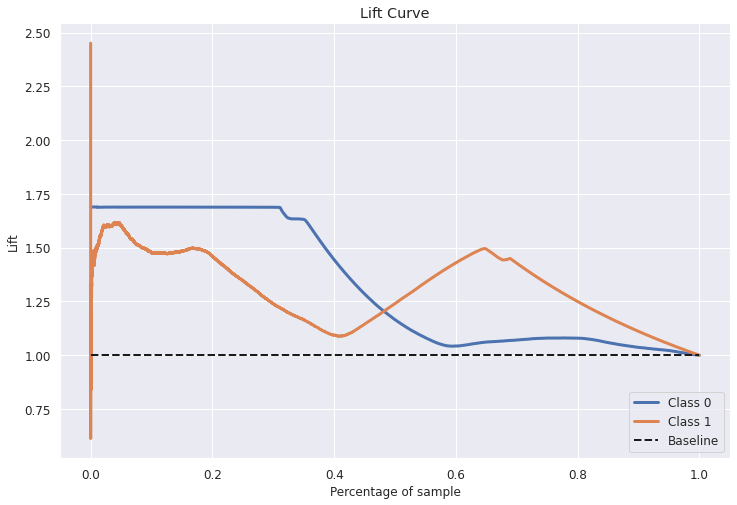

In [83]:
plot_lift_curve(y_val, yhat_lr);

### 9.2.1 Métrica Logistic Regression

In [84]:
# copy data
data = x_validation.copy()
data['response'] = y_validation.copy()

# propensity score
data['score'] = yhat_lr[:, 1].tolist()

# sorte clients by propensity score
data = data.sort_values('score', ascending=False)

# compute precision at k
precision_at_lr = precision_at_k(data, k=20000)
print('Precision at K: {}'.format(precision_at_lr))

# compute recall at k
recall_at_lr = recall_at_k(data, k=20000)
print('Recall at K: {}'.format(recall_at_lr))

# compute f1score at k
f1score_at_lr = f1score_at_k(data, k=20000)
print('F1score at K: {}'.format(f1score_at_lr))

Precision at K: 0.6084195790210489
Recall at K: 0.2710909131413041
F1score at K: 0.375065495453845


### 9.2.2 Cross Validation

In [85]:
lr_results_cv = cross_validation(lr(random_state=42), 'Logistic Regression',x_train, y_train,5,df7)
lr_results_cv


Kfold Number:1/5

Kfold Number:2/5

Kfold Number:3/5

Kfold Number:4/5

Kfold Number:5/5


,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD,F1score@K Mean,F1score@K STD
Logistic Regression,0.9928,+/- 0.0016,0.5524,+/- 0.0009,0.7099,+/- 0.0011


## 9.3 XGBoost Classifier

In [86]:
# model definition
xg_model = xgb(n_estimators=7,random_state=42)

# model training
xg_model.fit(x_train,y_train)

# model prediction
yhat_xg = xg_model.predict_proba(x_val)

[14:11:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


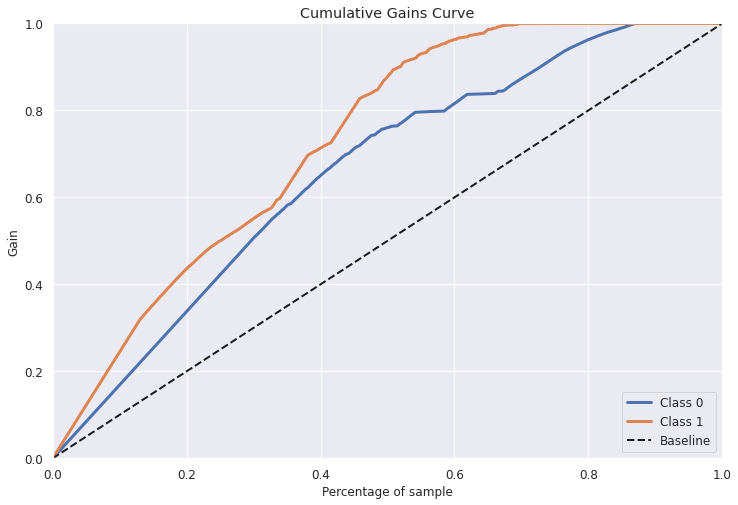

In [87]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_xg);

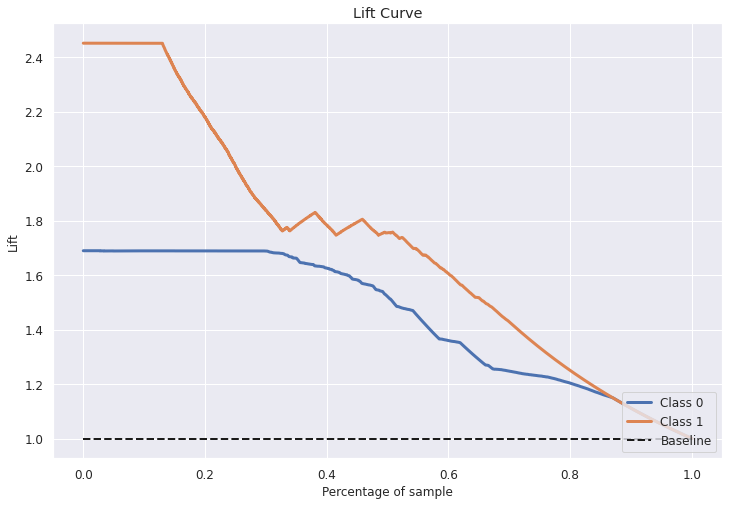

In [91]:
plot_lift_curve(y_val, yhat_xg);

### 9.3.1 Métrica XGB

In [92]:
# copy data
data = x_validation.copy()
data['response'] = y_validation.copy()

# propensity score
data['score'] = yhat_xg[:, 1].tolist()

# sorte clients by propensity score
data = data.sort_values('score', ascending=False)

# compute precision at k
precision_at_xg = precision_at_k(data, k=20000)
print('Precision at K: {}'.format(precision_at_xg))

# compute recall at k
recall_at_xg = recall_at_k(data, k=20000)
print('Recall at K: {}'.format(recall_at_xg))

# compute f1score at k
f1score_at_xg = f1score_at_k(data, k=20000)
print('F1score at K: {}'.format(f1score_at_xg))

Precision at K: 0.9136043197840108
Recall at K: 0.40707077457729063
F1score at K: 0.5631992602866389


### 9.3.2 Cross Validation

In [93]:
xgb_results_cv = cross_validation(xgb(random_state=42), 'XGBoost Classifier',x_train, y_train,5,df7)
xgb_results_cv


Kfold Number:1/5
[14:13:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Kfold Number:2/5
[14:13:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Kfold Number:3/5
[14:13:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Kfold Number:4/5
[14:13:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD,F1score@K Mean,F1score@K STD
XGBoost Classifier,1.0,+/- 0.0,0.5564,+/- 0.0,0.715,+/- 0.0


## 9.4 Decision Tree Classifier

In [94]:
from sklearn.tree import DecisionTreeClassifier

In [95]:
# model definition
dt_model = DecisionTreeClassifier(random_state=42)

# model training
dt_model.fit(x_train,y_train)

# model prediction
yhat_dt = dt_model.predict_proba(x_val)

### 9.4.1 Métrica Decision Tree Classifier


In [96]:
# copy data
data = x_validation.copy()
data['response'] = y_validation.copy()

# propensity score
data['score'] = yhat_dt[:, 1].tolist()

# sorte clients by propensity score
data = data.sort_values('score', ascending=False)

# compute precision at k
precision_at_dt = precision_at_k(data, k=20000)
print('Precision at K: {}'.format(precision_at_dt))

# compute recall at k
recall_at_dt = recall_at_k(data, k=20000)
print('Recall at K: {}'.format(recall_at_dt))

# compute f1score at k
f1score_at_dt = f1score_at_k(data, k=20000)
print('F1score at K: {}'.format(f1score_at_dt))

Precision at K: 0.7829608519574022
Recall at K: 0.34886052262246875
F1score at K: 0.48266296809986137


### 9.4.2 Cross Validation

In [97]:
dt_results_cv = cross_validation(DecisionTreeClassifier(random_state=42), 'Decision Tree Classifier',x_train, y_train,5,df7)
dt_results_cv


Kfold Number:1/5

Kfold Number:2/5

Kfold Number:3/5

Kfold Number:4/5

Kfold Number:5/5


,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD,F1score@K Mean,F1score@K STD
Decision Tree Classifier,0.8326,+/- 0.0029,0.4633,+/- 0.0016,0.5953,+/- 0.0021


## 9.5 Comparação dos Modelos


### 9.5.1 Performance Machine Learning

In [98]:
modelling_result_ml = pd.DataFrame({'Model':['KNN','Logistic Regression','XGBoost Classifier','Decision Tree'],
              'Precision@k':[precision_at_knn,precision_at_lr,precision_at_xg,precision_at_dt],
              'Recall@K':[recall_at_knn,recall_at_lr,recall_at_xg,recall_at_dt],
              'F1Score@K':[f1score_at_knn,f1score_at_lr,f1score_at_xg,f1score_at_dt]})

modelling_result_ml

,Model,Precision@k,Recall@K,F1Score@K
0,KNN,0.692215,0.308427,0.426722
1,Logistic Regression,0.608420,0.271091,0.375065
2,XGBoost Classifier,0.913604,0.407071,0.563199
3,Decision Tree,0.782961,0.348861,0.482663


### 9.5.2 Performance - Cross Validation

In [99]:
modelling_result_cv = pd.concat([knn_results_cv, lr_results_cv,xgb_results_cv,dt_results_cv])
modelling_result_cv

,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD,F1score@K Mean,F1score@K STD
KNeighbors Classifier,0.9808,+/- 0.0006,0.5458,+/- 0.0003,0.7013,+/- 0.0004
Logistic Regression,0.9928,+/- 0.0016,0.5524,+/- 0.0009,0.7099,+/- 0.0011
XGBoost Classifier,1.0,+/- 0.0,0.5564,+/- 0.0,0.715,+/- 0.0
Decision Tree Classifier,0.8326,+/- 0.0029,0.4633,+/- 0.0016,0.5953,+/- 0.0021


# 10.0 Hyperparameter Fine Tuning

In [101]:
# Encontrar o conjunto de parâmetro que maximiza o aprendizado do modelo

 ## 10.1 KNeighbors + GridSearch

In [102]:
 f1 = mtr.make_scorer(mtr.recall_score)

In [103]:
#  params_tuned = {
#       'n_neighbors': [3,5,11,15],
#       'weights':['uniform','distance'],
#       'metric':['euclidean','manhattan']
#  }

In [104]:
params_tuned = {
        'n_estimators' : [3,7,13],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [105]:
model_xg = GridSearchCV(
    xgb(), 
    param_grid=params_tuned,
    verbose = 1, 
    scoring=f1, 
    cv= 3,
)

model_final_xg = model_xg.fit(x_train,y_train)

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
[15:46:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss

[15:47:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:47:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:47:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:48:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:48:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:48:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:49:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:49:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:49:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:49:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:50:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:50:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:50:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:51:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:51:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:51:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:52:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:52:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:52:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:53:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:53:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:53:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:54:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:54:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:54:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:54:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:55:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:55:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:55:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:56:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:56:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:56:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:57:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:57:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:57:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:58:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:58:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:58:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:59:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:59:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:59:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:00:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:00:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:00:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:01:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:01:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:01:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:02:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:02:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:02:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:03:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:03:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:03:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:04:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:04:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:04:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:05:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:05:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:05:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:06:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:06:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:06:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:07:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:07:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:07:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:08:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:08:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:08:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:08:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:09:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:09:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:10:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:10:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:10:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:11:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:11:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:11:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:12:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:12:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:12:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:13:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:13:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:14:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:14:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:14:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:15:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:15:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:15:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:16:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:16:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:16:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:17:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:17:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:17:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:18:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:18:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:18:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:19:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:19:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:19:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:20:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:20:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:21:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:21:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:21:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:22:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:22:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:22:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:23:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:23:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [106]:
model_final_xg.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 13,
 'subsample': 0.6}

In [20]:
# model definition
final_xg_model = xgb(
                    n_estimators= 13,
                    colsample_bytree= 0.6,
                    gamma= 1,
                    max_depth= 5,
                    min_child_weight= 1,
                    subsample= 0.6,
                    random_state=42)


# model training
final_xg_model.fit(x_train,y_train)

# model prediction
yhat_xg_final = final_xg_model.predict_proba(x_val)

[15:32:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 10.1.1 Performance Final do modelo

In [21]:
final_results_cv = cross_validation(final_xg_model, 'XGBoost Classifier',x_train, y_train,5,df7)
final_results_cv


Kfold Number:1/5
[15:32:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Kfold Number:2/5
[15:32:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Kfold Number:3/5
[15:32:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Kfold Number:4/5
[15:32:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD,F1score@K Mean,F1score@K STD
XGBoost Classifier,0.3075,+/- 0.0022,0.8254,+/- 0.0058,0.4481,+/- 0.0032


# 11.0 Interpletação do Erro

### 11.3.1 - Quais são os principais insights sobre os atributos mais relevantes de clientes relevantes na compra de seguro de automóveis.

**1. Clientes com idade maior que 40 anos tem maior interesse em contratar seguro.**

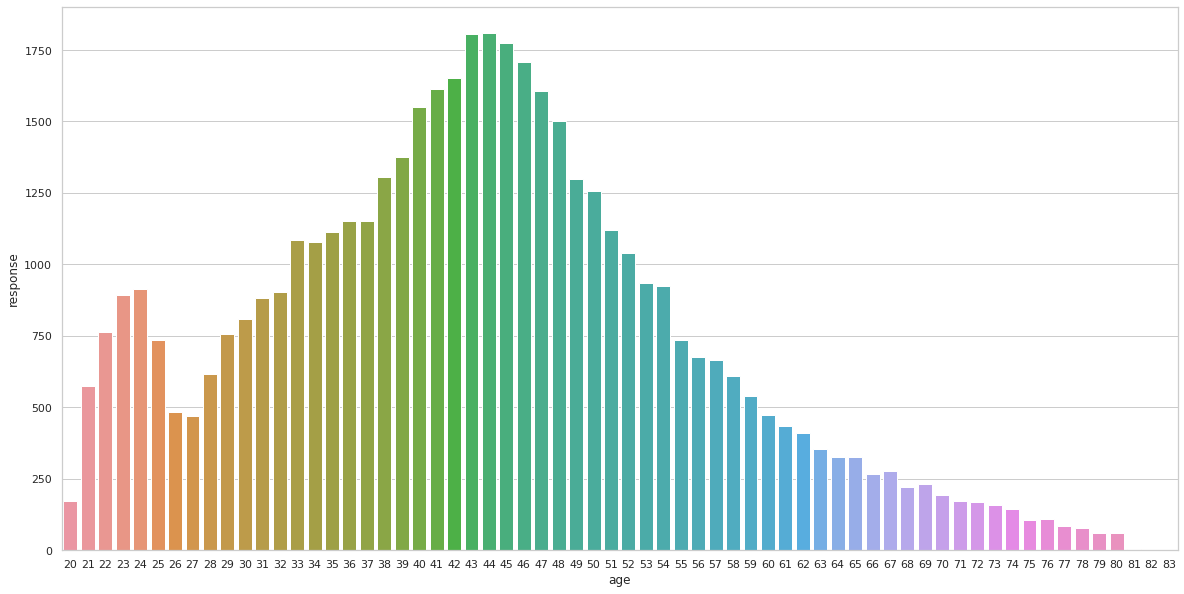

In [108]:
plt.figure(figsize=(20,10))
aux = df6[df6['response']== 1]

aux1 = aux[['age', 'response']].groupby('age').sum().reset_index()


sns.barplot(x='age',y='response', data=aux1);

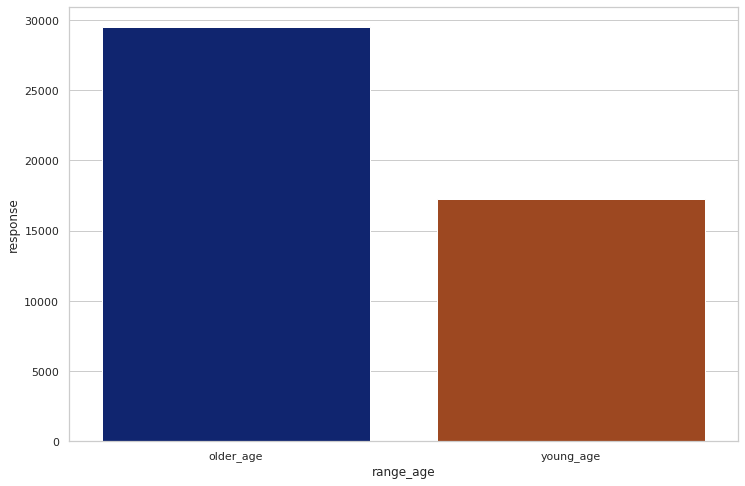

In [109]:
aux['range_age'] = aux['age'].apply(lambda x: 'young_age' if x < 40 else 'older_age')
aux1 = aux[['range_age', 'response']].groupby('range_age').sum().reset_index()

ax = sns.barplot(x='range_age', y='response', data= aux1,palette='dark');


#### 1- Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

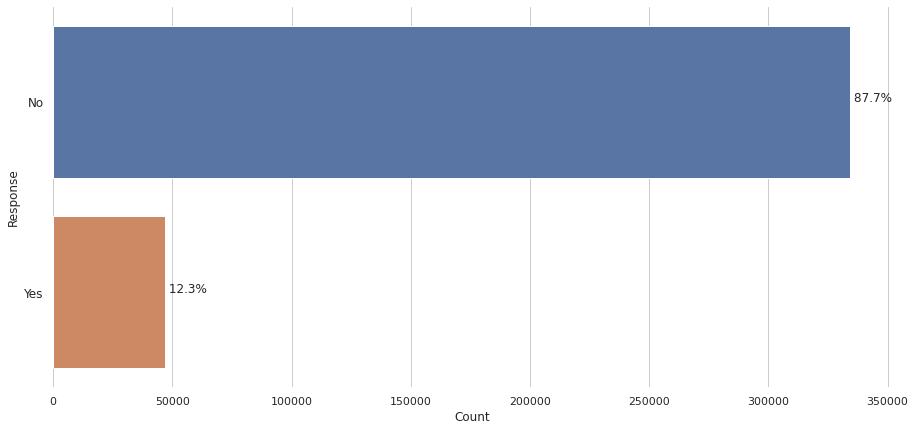

In [109]:
plt.figure(figsize=(15,7))
aux = sns.countplot(y='response', data=df6);
sns.set_style('whitegrid')
plt.xlabel('Count')
plt.ylabel('Response')
plt.yticks(np.arange(2),['No','Yes'], size=12)
sns.despine( bottom=True, left=True)


total = df3['response'].size

for p in aux.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        aux.annotate(percentage, (x, y))

Podemos perceber apenas 12,3% das pessoas tem interesse em adquirir o seguro de carro e  que cerca de 87,7% das pessoas não tem interesse em adquirir o seguro de carro. 

Considerações:

- Analise dos dados de campanha publicitária da empresa;
- Coletar mais dados para entender melhor o comportamento e assim criar estratégias de negócios para alcançar um maior público.

#### 2- Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [110]:
data = x_validation.copy()

data['response'] = y_validation.copy()
data['score'] = yhat_xg_final[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [111]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)

print(percent_of_dataset)
print(recall_at_20000)

0.2623914355435439
0.7056583818085669


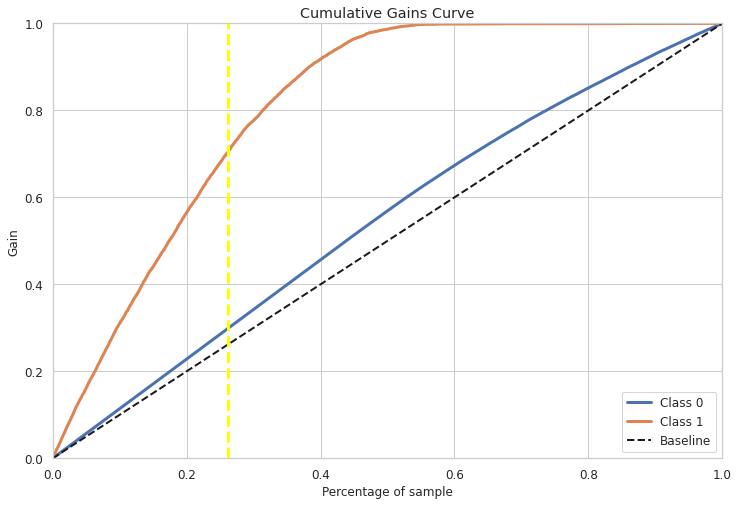

In [112]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xg_final)
plt.axvline(0.2623, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

O modelo apresentou um resultado final de precisão de 24,21%. Com este modelo podemos contactar 4.842 (Sendo no melhor cenário 4.858 e no pior cenário 4.826 )clientes interessados em seguro de carro numa base de  20.000 ligações. Já o recall é de cerca de 89,3%(+/-0,0022).



#### 3- E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

O modelo apresentou um resultado final de precisão de 33,18% (consertando o desvio padrão para entender a performance final) Com este modelo podemos contactar 13.272 clientes interessados em seguro de carro em 20.000 ligações. Já o recall é de cerca de 89,3%(std).

#### 4- Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

O modelo classificou 89,3% no total de 



O modelo classificou 98,31% (46.084 clientes) do cliente interessado em 50% da base de dados com 381.109 clientes. Com o modelo, é possível contatar 80% dos clientes interessados em seguro saúde em 155.064 (155.064 para um desempenho excelente ou 155.064 para um desempenho ruim).

# testes

In [ ]:
def ml_models(x_treino,y_treino):
  # model definition
  dt_model = DecisionTreeClassifier(random_state=42)

  # model training
  dt_model.fit(x_train,y_train)

  # model prediction
  yhat_dt = dt_model.predict_proba(x_val)

# 12.0 Deploy do modelo

In [22]:
pickle.dump(final_xg_model,open('/home/bruna/Documentos/pa004_health_insurance_cross_sell/src/models/model_xgboost.pkl','wb'))

 ## 12.1 Classe Health Insurance 

In [58]:
class HealthInsurance(object):
    
    def _init_(self):
        self.home_path = '/home/bruna/Documentos/pa004_health_insurance_cross_sell/src'
        self.age_scaler                                 = pickle.load(open(self.home_path + 'features/age_scaler.pkl','rb'))
        self.annual_premmium_scaler                     = pickle.load(open(self.home_path + 'features/annual_premmium_scaler.pkl','rb'))
        self.fe_policy_sales_channel_scaler             = pickle.load(open(self.home_path + 'features/fe_policy_sales_channel_scaler.pkl','rb'))
        self.target_encode_gender_scaler                = pickle.load(open(self.home_path + 'features/target_encode_gender_scaler.pkl','rb'))
        self.target_encode_region_code                  = pickle.load(open(self.home_path + 'features/target_encode_region_code_scaler.pkl','rb'))
        self.target_vintage_scaler                      = pickle.load(open(self.home_path + 'features/vintage_scaler.pkl','rb'))
     
    
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new

        return df1 

    
    def feature_engineer (self, df4):
        
        # Age
        df4['age_range']= df4['age'].apply(lambda y: 'young' if y <= 21 else 'adult' if 21 < y < 60 else 'old' if y >= 60 else 'children') 

        # Vehicle Age
        df4['vehicle_age']= df4['vehicle_age'].apply(lambda y: 'below_1_year' if y == '< 1 Year' else 'between_1_2_year' if y == '1-2 Year'  else 'over_2_years') 

        # Vehicle Damage
        vehicle_damage_dict = {'No': 0,
                               'Yes': 1}

        df4['vehicle_damage']= df4['vehicle_damage'].map(vehicle_damage_dict)

        # Gender
        df4['gender_binary']= df4['gender'].apply(lambda y: 0 if y == 'Female' else 1) 
        
        return df4
    
    def data_preparation (self, df7):

        #age
        df7['age'] = self.age_scaler.transform( df7[['age']].values )

        #vintage
        df7['vintage'] = self.target_vintage_scaler.transform(df7[['vintage']].values )
        

        #gender
        df7.loc[:,'gender']= df7['gender'].map(self.target_encode_gender_scaler)
       
        #region_code
        df7.loc[:,'region_code']= df7['region_code'].map(self.target_encode_region_code )
        
        #vehicle_age
        df7 = pd.get_dummies(df7,prefix='vehicle_age',columns=['vehicle_age']) # em dúvida

        #policy_sales_channel
        df7.loc[:,'policy_sales_channel']= df7['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler )
       
        #annual_premium
        df7['annual_premium'] = self.annual_premmium_scaler.transform( df7[['annual_premium']].values )
        
        cols_selected =['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']
        
        return df7[cols_selected]
        
    def get_predictions(self,model,original_data,test_data):
        
        #model prediction
        pred = model.predict_proba(test_data)
        
        #join prediction into original data
        original_data['prediction'] = pred

        
        return original_data.to_json(orient='records', date_format='iso')

##  12.2 API Handler

In [64]:
import pickle
import pandas as pd
from flask  import Flask, request, Response

import health_insurance




#/home/bruna/Documentos/pa004_health_insurance_cross_sell/src/models
#loading model
path = '/home/bruna/Documentos/pa004_health_insurance_cross_sell'
model = pickle.load(open(path + '/src/models/model_xgboost.pkl','rb')) 

#initialize API
app = Flask( __name__ )

@app.route('/predict',methods=['POST'])

def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json,dict):
            test_raw = pd.DataFrame(test_json,index=[0])
        
        else: # multiple example
            test_raw = pd.DataFrame(test_json,columns=test_json[0].keys())
            
        #Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df4 = pipeline.feature_engineering(df1)
        
        #data preparation
        df7 = pipeline.data_preparation(df4)
        
        # prediction
        df_response = pipeline.get_prediction(model,test_raw,df7)
        
        return df_response
    
    else:
        
        return Response('{}', status=200,mimetype='application/json')
        
        
if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


OSError: [Errno 9] Bad file descriptor

##  12.3 API Teste

In [48]:
import requests

In [49]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [50]:
 df_test = df_test.sample(10)

In [51]:
data = json.dumps( df_test.to_dict( orient='records' ) )

In [52]:
#API Call
url = 'http://0.0.0.0:5000/predict'
header = {'Content-type':'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

KeyboardInterrupt: 